In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import pandas as pd
import numpy as np

from split_utils import read_fasta, Identity, compute_identity_stats
import matplotlib.pyplot as plt

# Load clusters

In [3]:
clusters = pd.read_csv(".cache/mmseqs/clusters.tsv", sep="\t", header=None)
clusters.columns = ["reference_sequence_id", "sequence_id"]

# Split clusters into two sets

In [4]:
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['reference_sequence_id'].unique()
    print("Found", len(cluster_ids), "clusters.")
    n_test = int(len(cluster_ids) * test_ratio) # Number of clusters to be used for testing
    test_clusters = set(cluster_ids[:n_test])
    train_clusters = set(cluster_ids[n_test:])
    train_ids = clusters[clusters['reference_sequence_id'].isin(train_clusters)]['sequence_id'].tolist()
    test_ids = clusters[clusters['reference_sequence_id'].isin(test_clusters)]['sequence_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(clusters)

Found 7687 clusters.


# Assert independence between training and test sets

In [5]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")


 100%|██████████████████████████████████████|  4613/4613 [10:35<00:00, 7.40it/s] 


Max identity: 1.0
Mean identity: 0.7278405554057671
Median identity: 0.7692307692307693
Quantiles:
- 0.01 quantile: 0.35714285714285715
- 0.05 quantile: 0.4186046511627907
- 0.10 quantile: 0.46153846153846156
- 0.25 quantile: 0.5833333333333334
- 0.50 quantile: 0.7692307692307693
- 0.75 quantile: 0.8823529411764706
- 0.90 quantile: 0.9166666666666666
- 0.95 quantile: 0.9285714285714286
- 0.99 quantile: 0.9473684210526315
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
4348


Text(0, 0.5, 'Frequency')

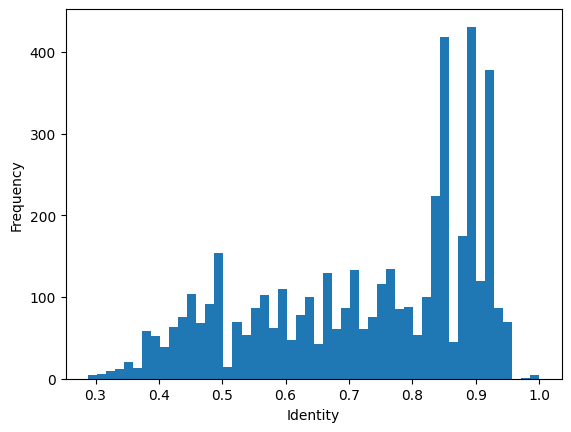

In [6]:
print(f"Max identity: {np.max(identities)}")
print(f"Mean identity: {np.mean(identities)}")
print(f"Median identity: {np.median(identities)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(identities, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(identities, bins=50)
plt.xlabel("Identity")
plt.ylabel("Frequency")